Имеются данные по выдачам кредитов и платежам: плановым и фактическим. Данные актуальны на 08.12.2022. Необходимо проанализировать характер поведения клиентов с точки зрения просрочки, определить динамику просрочки. Просрочка — нарушение должником сроков и/или объёмов исполнения обязательств, предусмотренных договором (графиком платежей).

order_id – номер заявки
created_at - дата создания заявки
put_at - дата выдачи
closed_at - дата закрытия
issued_sum - сумма выдачи

plan_at - дата планового платежа
plan_sum_total - сумма планового платежа (накопленным итогом)

paid_at - дата фактического платежа
paid_sum - сумма фактического платежа

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
orders = pd.read_csv('orders.csv') #есть пустые строки в closet_at
payments = pd.read_csv('payments.csv') #ежемесячная сумма paid_sum
plan = pd.read_csv('plan.csv')  #накопительная сумма plan_sum_total

In [22]:
payments.loc[payments.duplicated()]
payments = payments.drop_duplicates()  #удаление дубликатов

In [23]:
# Привожу к типу дат и единому формату
payments['paid_at'] = pd.to_datetime(payments['paid_at']).dt.normalize()
orders['closed_at'] = pd.to_datetime(orders['closed_at']).dt.normalize()
plan['plan_at'] = pd.to_datetime(plan['plan_at'])

In [24]:
#По условию данные актуальны до 08.12.2022
plan= plan.query('plan_at <= "2022-12-08"')
payments = payments.query('paid_at <= "2022-12-08"')

Дополнительное вычисление по плановым платежам:

In [25]:
plan = plan.sort_values(by=['order_id', 'plan_at'])
# Вычисляю плановые платежи по месяцам (без накопления)
plan['plan_sum'] = plan['plan_sum_total'].diff().fillna(plan['plan_sum_total'])
# Заменяю значения, если больше нуля, то остается без изменений, если меньше или равно, то plan_sum_total
plan['plan_sum'] = plan['plan_sum'].where(plan['plan_sum'] > 0 , plan['plan_sum_total'])

In [26]:
# Присваиваю ранг по каждому платежу (по возрастанию) внутри каждого order_id
plan['plan_rank'] = plan.groupby('order_id')['plan_at'].rank(method='first')

Дополнительное вычисление по фактическим платежам:

In [27]:
payments = payments.sort_values(by=['order_id', 'paid_at'])
# Расчитываю накопительную сумму по фактическим платежам для каждого order_id
payments['paid_sum_total'] = payments.groupby('order_id')['paid_sum'].cumsum()
# Присваиваю ранг по каждому платежу (по возрастанию) внутри каждого order_id
payments['payments_rank'] = payments.groupby('order_id')['paid_at'].rank(method='first')

In [28]:
# Объединяю заказы
plan_payments =pd.merge(plan, payments, left_on=['order_id', 'plan_rank'], right_on=['order_id', 'payments_rank'], how='outer')

In [29]:
# Удаляю все строки,где отсутствует дата планового платежа (платеж одной датой без графика)
plan_payments = plan_payments.dropna(subset=['plan_at'])

Проверяю какие платежи были сразу закрыты по таблице orders, удаляю их из данных

In [30]:
merged_df = pd.merge(plan_payments, orders, on='order_id', how='left')
filtered = merged_df[(merged_df['plan_at'] == merged_df['closed_at']) & (merged_df['plan_rank'] == 1)]

In [31]:
order_ids_filtered = filtered['order_id']
# Удаляю записи из plan_payments, где order_id совпадает с извлеченными
plan_payments = plan_payments[~plan_payments['order_id'].isin(order_ids_filtered)]

Отфильтрую все записи, которые по условию являются просрочкой - нарушение должником сроков и/или объёмов исполнения обязательств, предусмотренных графиком платежей

In [32]:
# Условия для фильтрации
condition1 = plan_payments['plan_at'] < plan_payments['paid_at']
condition2 = plan_payments['plan_sum_total'] > plan_payments['paid_sum_total']
condition3 = plan_payments['paid_at'].isnull()

plan_payments = plan_payments[condition1 |  condition2 | condition3]

Так как все значения в таблице plan_payments являются просрочкой, то могу считать значения в столбце plan_sum суммой просрочки по месяцам. Извлеку из плановой даты оплаты месяц для дальнейшей группировки

In [33]:
plan_payments['month'] = plan_payments['plan_at'].dt.month

Группирую по месяцам и заказам и считаю сумму просрочки (уникальные заказы)

In [34]:
delay_order_id = plan_payments.groupby(['month', 'order_id']).agg(sum=('plan_sum', 'sum')).reset_index()

Далее считаю сумму просрочки и количество заказов с просрочкой (по месяцам)

In [35]:
# Количество заказов с просрочкой по месяцам
delay_count_order = delay_order_id.groupby('month').agg(count_order=('order_id', 'count')).reset_index()

# Сумма просрочки по месяцам
delay_sum = delay_order_id.groupby('month').agg(sum_delay=('sum', 'sum')).reset_index()

Строю графики для определения динамики по просрочке

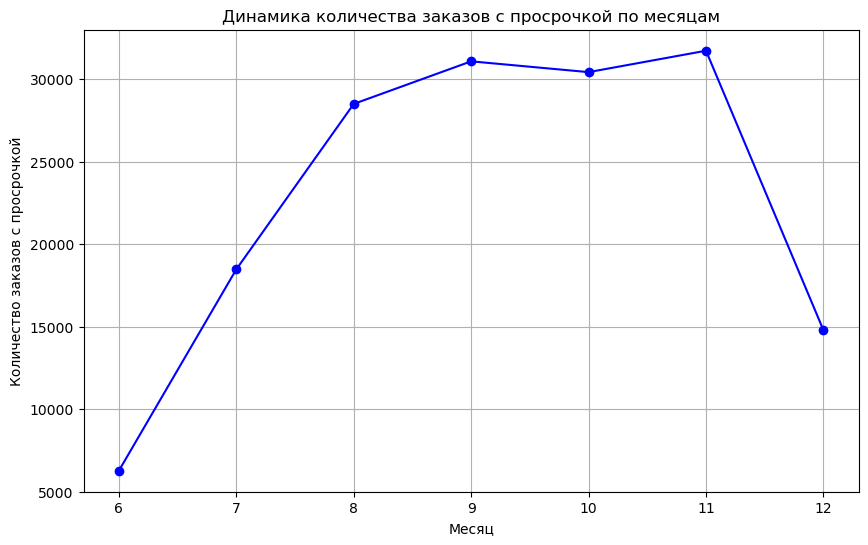

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(delay_count_order['month'], delay_count_order['count_order'], marker='o', linestyle='-', color='b')

plt.title('Динамика количества заказов с просрочкой по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов с просрочкой')
plt.grid()

plt.show()

Вывод: В период с июня по ноябрь 2022 года наблюдается рост значений по количесту заказов с просрочкой, максимальное значением в ноябре составляет более 30тысяч заказов, по данным декабря есть актуальные значения только до середины месяца, поэтому их не учитываю в выводе.

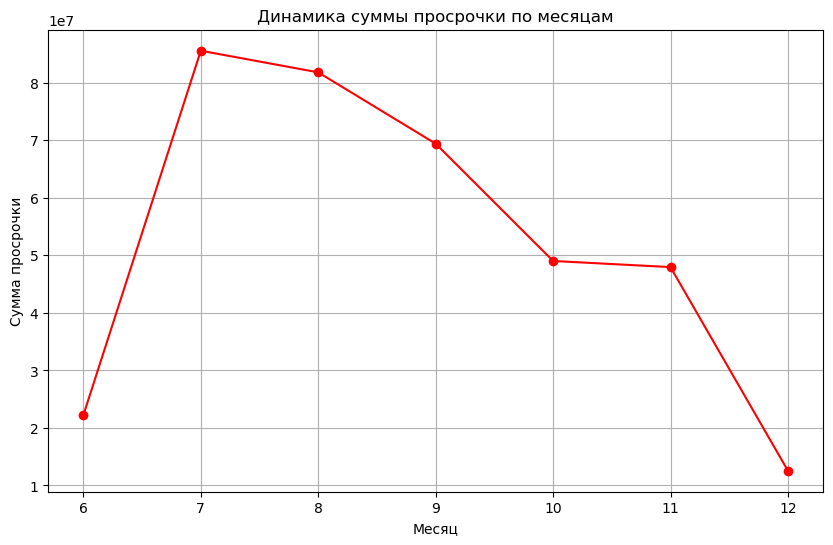

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(delay_sum['month'], delay_sum['sum_delay'], marker='o', linestyle='-', color='r')

plt.title('Динамика суммы просрочки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма просрочки')
plt.grid()

plt.show()

Вывод: В период с июля по ноябрь 2022 года наблюдается тенденция к снижению просрочки по сумме, максимальное значение зафиксировано в июле, по данным декабря есть актуальные значения только до середины месяца, поэтому их не учитываю в выводе.